In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [34 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-_rhg0anb/pyyaml_a2f206d8a37e41ad9facbe400aab8427/setup.py", line 291, in <module>
          setup(
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/core.py", line 185, in setup
          return run_commands(dist)
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/core.py", line 201, in run_commands
          dist.run_commands()
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/dist.py", line 969, in run_commands
          self.run_command(cmd)
        File "/opt/conda/lib/pyth

In [3]:
# Import libraries
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Function to display images inline in Jupyter
def display_image(image, title=""):
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()


In [4]:
!wget https://s3.amazonaws.com/udacity-sdc/annotations/object-detection-crowdai.tar.gz
!wget https://raw.githubusercontent.com/udacity/self-driving-car/master/annotations/labels_crowdai.csv

--2024-05-28 13:11:46--  https://s3.amazonaws.com/udacity-sdc/annotations/object-detection-crowdai.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.235.248, 52.216.32.40, 52.216.50.160, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.235.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1650810880 (1.5G) [application/x-gzip]
Saving to: 'object-detection-crowdai.tar.gz'

object-detection-cr 100%[===================>]   1.54G  37.4MB/s    in 43s     

2024-05-28 13:12:30 (36.8 MB/s) - 'object-detection-crowdai.tar.gz' saved [1650810880/1650810880]

--2024-05-28 13:12:31--  https://raw.githubusercontent.com/udacity/self-driving-car/master/annotations/labels_crowdai.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 O

In [5]:
!tar xf object-detection-crowdai.tar.gz

In [6]:
import pandas as pd

df = pd.read_csv('labels_crowdai.csv')

df.head()

xmin  ymin  xmax  ymax                    Frame  Label  \
0   785   533   905   644  1479498371963069978.jpg    Car   
1    89   551   291   680  1479498371963069978.jpg    Car   
2   268   546   383   650  1479498371963069978.jpg    Car   
3   455   522   548   615  1479498371963069978.jpg  Truck   
4   548   522   625   605  1479498371963069978.jpg  Truck   

                                         Preview URL  
0  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...  
1  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...  
2  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...  
3  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...  
4  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...

In [7]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools
import cv2

# write a function that loads the dataset into detectron2's standard format
def get_data_dicts(csv_file, img_dir):
    df = pd.read_csv(csv_file)
    df['filename'] = df['Frame'].map(lambda x: img_dir + x)

    classes = df['Label'].unique().tolist()

    df['class_int'] = df['Label'].map(lambda x: classes.index(x))

    dataset_dicts = []
    for idx, filename in enumerate(df['filename'].unique().tolist()):
        record = {}

        #height, width = cv2.imread(filename).shape[:2]

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = 1200
        record["width"] = 1920

        objs = []
        for index, row in df[(df['filename']==filename)].iterrows():
          obj= {
              'bbox': [row['xmin'], row['ymin'], row['xmax'], row['ymax']],
              'bbox_mode': BoxMode.XYXY_ABS,
              'category_id': row['class_int'],
              "iscrowd": 0
          }
          objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [8]:
from detectron2.data import DatasetCatalog, MetadataCatalog

classes = df['Label'].unique().tolist()

DatasetCatalog.register('crowdai_vehicle_detection', lambda: get_data_dicts('labels_crowdai.csv' , 'object-detection-crowdai/'))
MetadataCatalog.get('crowdai_vehicle_detection').set(thing_classes=classes)
vehicle_detection_metadata = MetadataCatalog.get('crowdai_vehicle_detection')


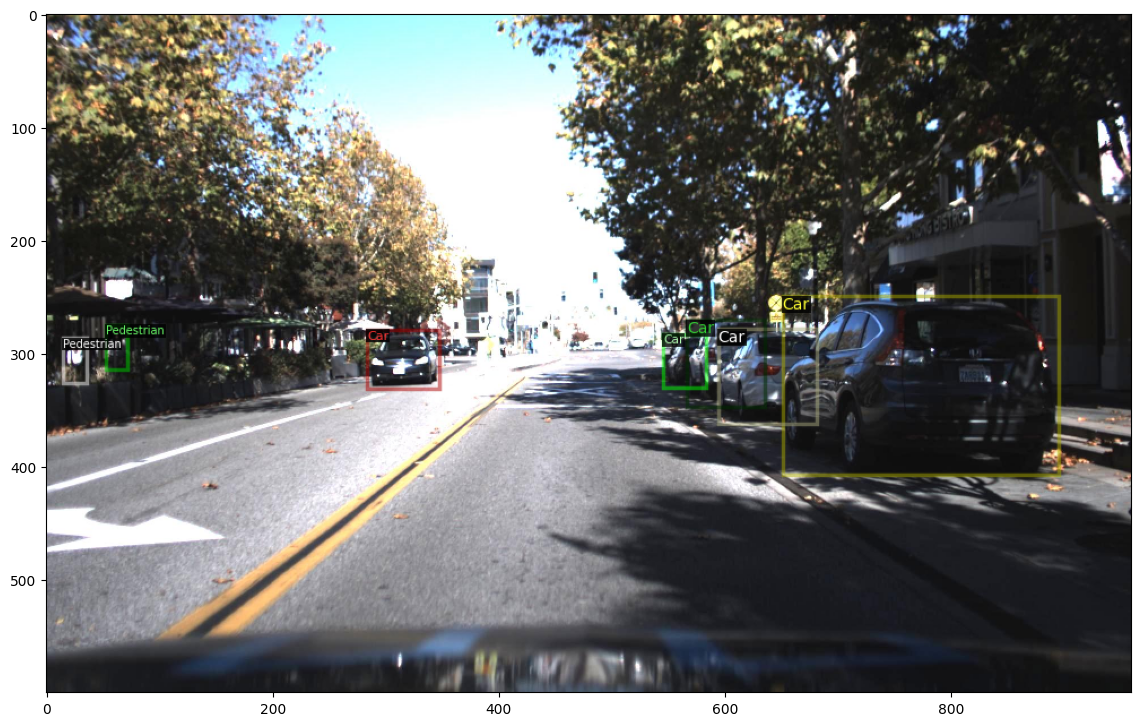

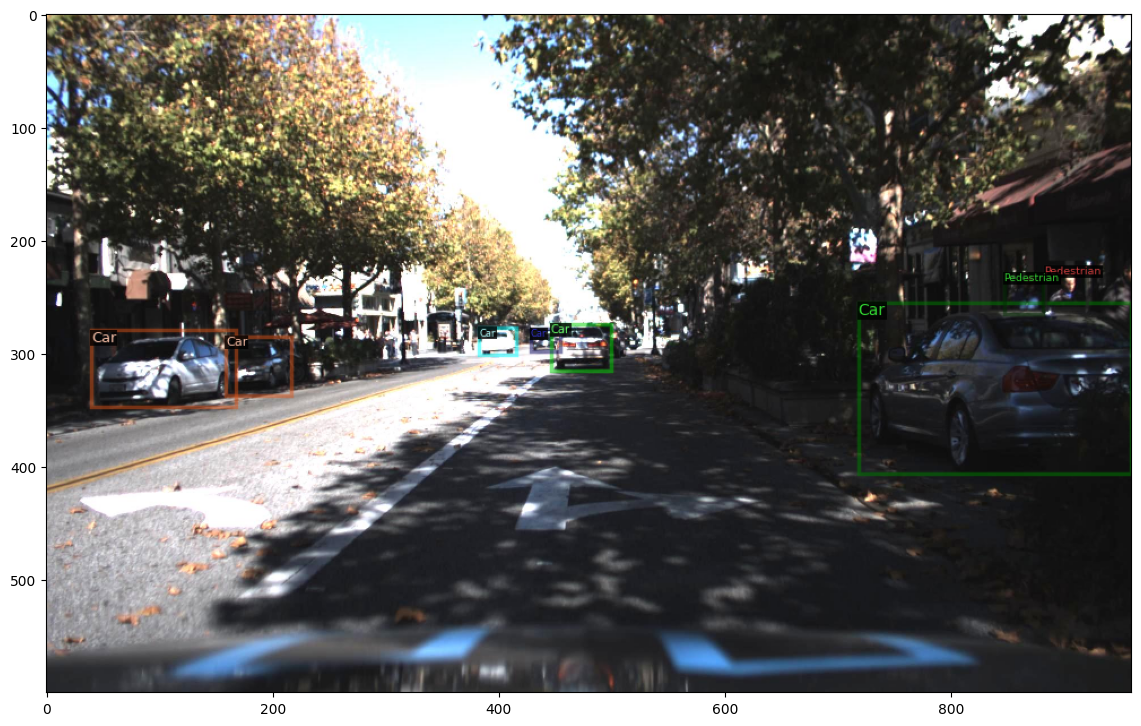

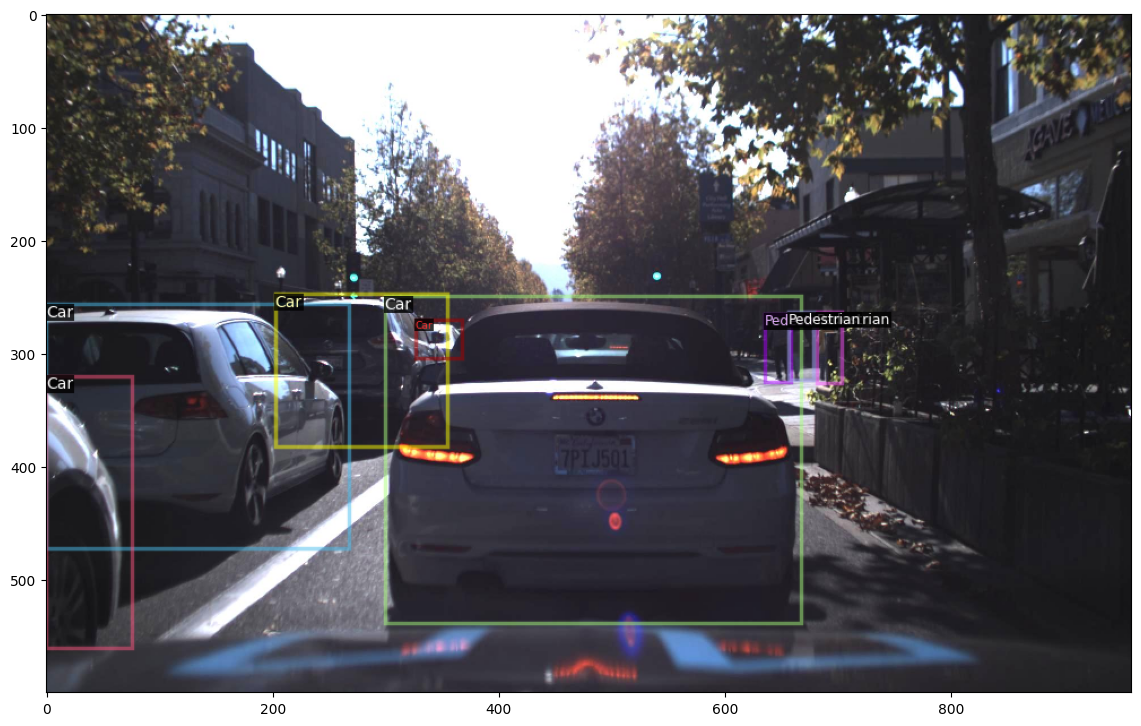

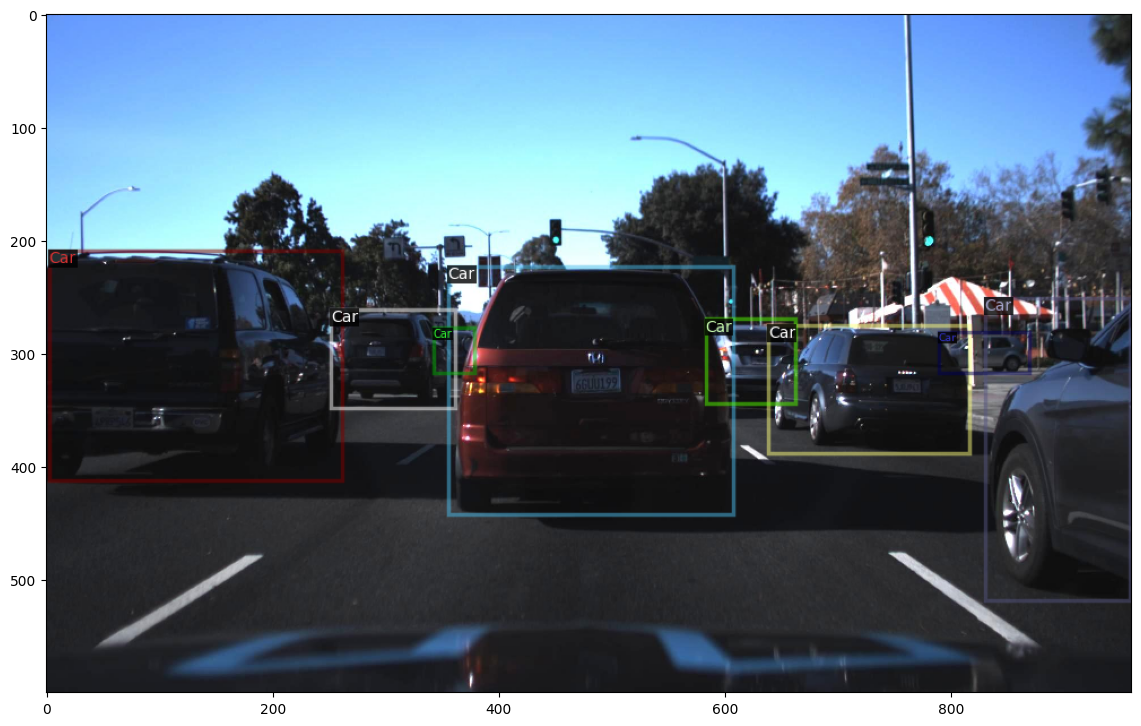

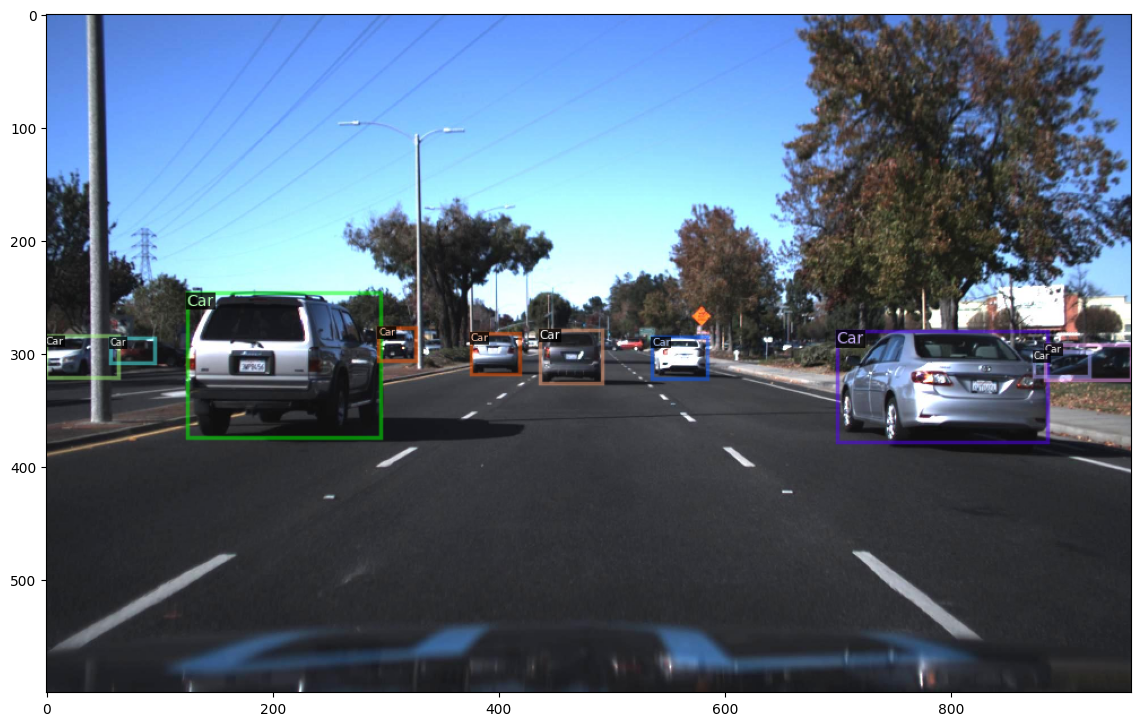

In [9]:
import random
from detectron2.utils.visualizer import Visualizer
from matplotlib import pyplot as plt
dataset_dicts = DatasetCatalog.get('crowdai_vehicle_detection')
for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=vehicle_detection_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [10]:
import os
import logging
import time
from detectron2.engine import DefaultTrainer, HookBase
from detectron2.config import get_cfg
from detectron2 import model_zoo
from tabulate import tabulate

# Configure logging
log_file = 'training_log.txt'
logging.basicConfig(filename=log_file, level=logging.INFO)

# Print message to console to confirm logging setup
print(f"Logging to {log_file}")

# List of learning rates to experiment with
learning_rates = [0.001, 0.005, 0.01]

# Number of iterations and runs
num_iterations = 1000
num_runs = 10

# Data structure to store results
results = []

# Custom hook to log the training progress
class LossLoggerHook(HookBase):
    def __init__(self):
        super().__init__()

    def after_step(self):
        if self.trainer.storage.iter % 20 == 0:  # Log every 20 iterations
            total_loss = self.trainer.storage.history("total_loss").latest()
            logging.info(f"iter: {self.trainer.storage.iter} total_loss: {total_loss}")
            print(f"Logged iteration {self.trainer.storage.iter}")

# Function to train with a specific learning rate
def train_with_learning_rate(lr):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
    cfg.DATASETS.TRAIN = ('crowdai_vehicle_detection',)
    cfg.DATASETS.TEST = ()  # no metrics implemented for this dataset
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.MAX_ITER = num_iterations
    cfg.SOLVER.STEPS = []  # do not decay learning rate
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
    cfg.SOLVER.BASE_LR = lr  # Set learning rate

    # Implement gradient clipping correctly
    cfg.SOLVER.CLIP_GRADIENTS.ENABLED = True
    cfg.SOLVER.CLIP_GRADIENTS.CLIP_TYPE = "norm"
    cfg.SOLVER.CLIP_GRADIENTS.CLIP_VALUE = 1.0

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    trainer = DefaultTrainer(cfg)
    trainer.register_hooks([LossLoggerHook()])

    start_time = time.time()
    trainer.resume_or_load(resume=False)
    trainer.train()
    end_time = time.time()

    # Get the minimum loss over all iterations
    min_loss = min(trainer.storage.history("total_loss").values())

    return min_loss, end_time - start_time

# Run training for each learning rate
for lr in learning_rates:
    lr_results = []
    for run in range(num_runs):
        logging.info(f"Starting training with learning rate: {lr}, run: {run + 1}")
        print(f"Starting training with learning rate: {lr}, run: {run + 1}")
        min_loss, duration = train_with_learning_rate(lr)
        lr_results.append([lr, run + 1, min_loss, duration])
    results.extend(lr_results)

# Aggregate results for each learning rate
summary_results = []
for lr in learning_rates:
    lr_runs = [result for result in results if result[0] == lr]
    min_loss = min(lr_runs, key=lambda x: x[2])[2]
    total_time = sum(run[3] for run in lr_runs)
    summary_results.append([lr, min_loss, total_time])

# Tabulate the detailed results for each run
headers = ["Learning Rate", "Run", "Minimum Loss", "Duration (s)"]
print(tabulate(results, headers, floatfmt=".6f"))

# Log the detailed results to the file
logging.info(tabulate(results, headers, floatfmt=".6f"))

# Tabulate and print the summary results
summary_headers = ["Learning Rate", "Minimum Loss", "Total Time (s)"]
print(tabulate(summary_results, summary_headers, floatfmt=".6f"))

# Log the summary results to the file
logging.info(tabulate(summary_results, summary_headers, floatfmt=".6f"))

# Tabulate the detailed results for each learning rate
for lr in learning_rates:
    lr_runs = [result for result in results if result[0] == lr]
    print(f"\nDetailed results for learning rate: {lr}")
    print(tabulate(lr_runs, headers, floatfmt=".6f"))
    logging.info(f"\nDetailed results for learning rate: {lr}")
    logging.info(tabulate(lr_runs, headers, floatfmt=".6f"))


Logging to training_log.txt
Starting training with learning rate: 0.001, run: 1
[05/28 13:14:45 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (n

model_final_f6e8b1.pkl: 243MB [00:00, 247MB/s]                             


[05/28 13:16:47 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Logged iteration 0
[05/28 13:16:59 d2.utils.events]:  eta: 0:06:56  iter: 19  total_loss: 2.542  loss_cls: 1.764  loss_box_reg: 0.708  loss_rpn_cls: 0.03778  loss_rpn_loc: 0.0449    time: 0.4197  last_time: 0.4281  data_time: 0.0161  last_data_time: 0.0052   lr: 1.9981e-05  max_mem: 3478M


2024-05-28 13:17:01.220927: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 13:17:01.221022: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 13:17:01.345893: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Logged iteration 20
[05/28 13:17:17 d2.utils.events]:  eta: 0:06:31  iter: 39  total_loss: 2.353  loss_cls: 1.711  loss_box_reg: 0.5658  loss_rpn_cls: 0.0369  loss_rpn_loc: 0.03863    time: 0.4089  last_time: 0.3937  data_time: 0.0063  last_data_time: 0.0060   lr: 3.9961e-05  max_mem: 3479M
Logged iteration 40
[05/28 13:17:25 d2.utils.events]:  eta: 0:06:35  iter: 59  total_loss: 2.313  loss_cls: 1.574  loss_box_reg: 0.6508  loss_rpn_cls: 0.03265  loss_rpn_loc: 0.04875    time: 0.4110  last_time: 0.4485  data_time: 0.0063  last_data_time: 0.0057   lr: 5.9941e-05  max_mem: 3479M
Logged iteration 60
[05/28 13:17:33 d2.utils.events]:  eta: 0:06:14  iter: 79  total_loss: 1.978  loss_cls: 1.356  loss_box_reg: 0.5627  loss_rpn_cls: 0.03005  loss_rpn_loc: 0.04258    time: 0.4078  last_time: 0.3898  data_time: 0.0061  last_data_time: 0.0055   lr: 7.9921e-05  max_mem: 3479M
Logged iteration 80
[05/28 13:17:41 d2.utils.events]:  eta: 0:06:16  iter: 99  total_loss: 1.791  loss_cls: 1.074  loss_bo

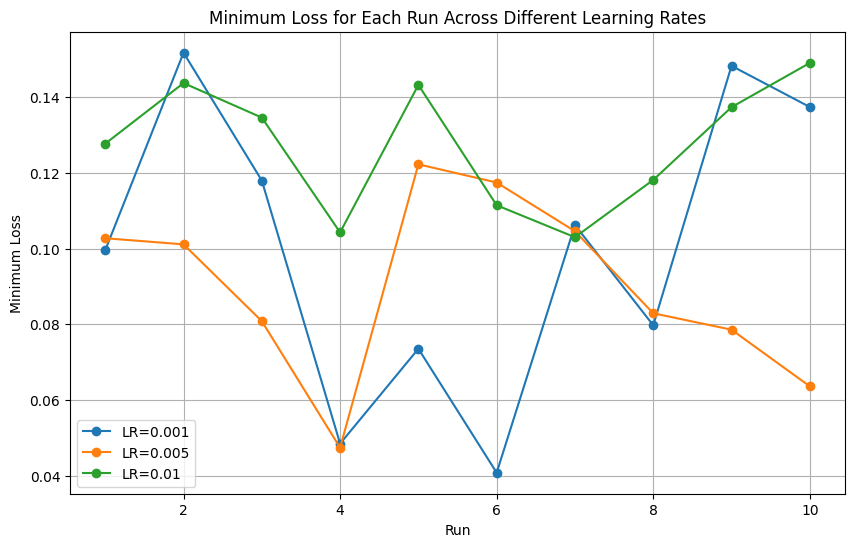

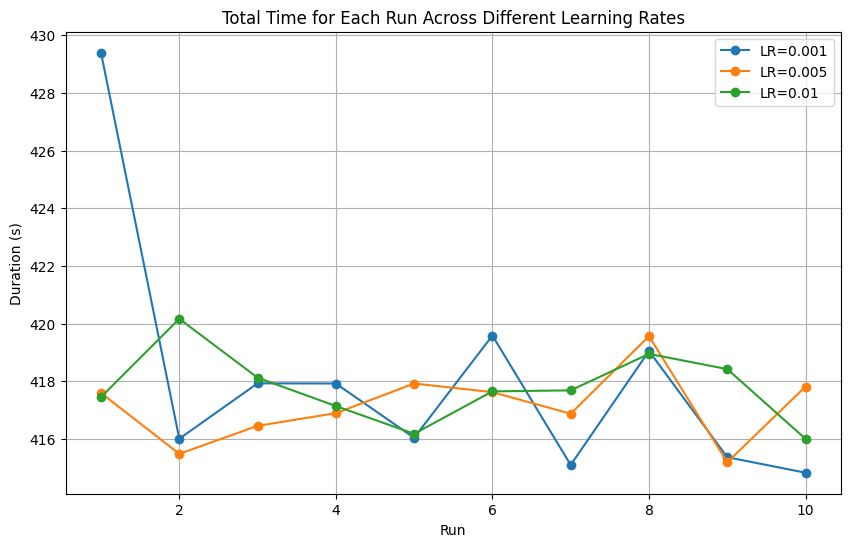

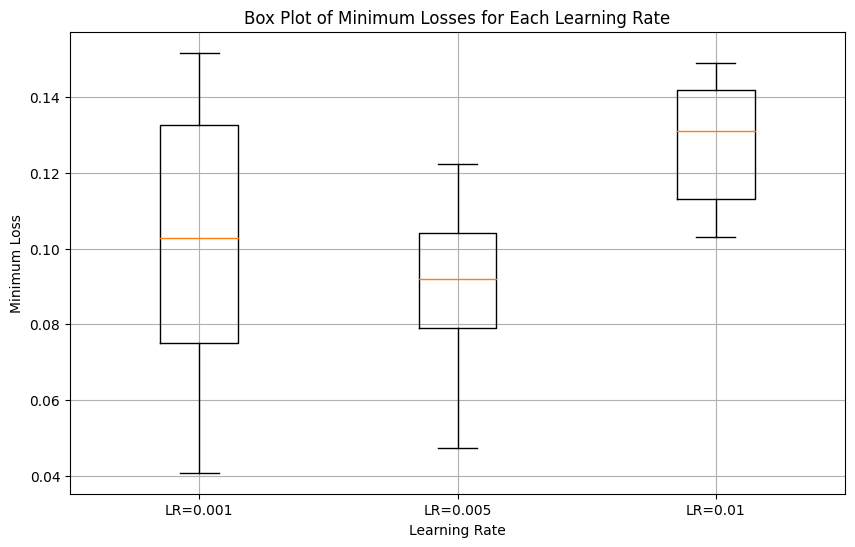

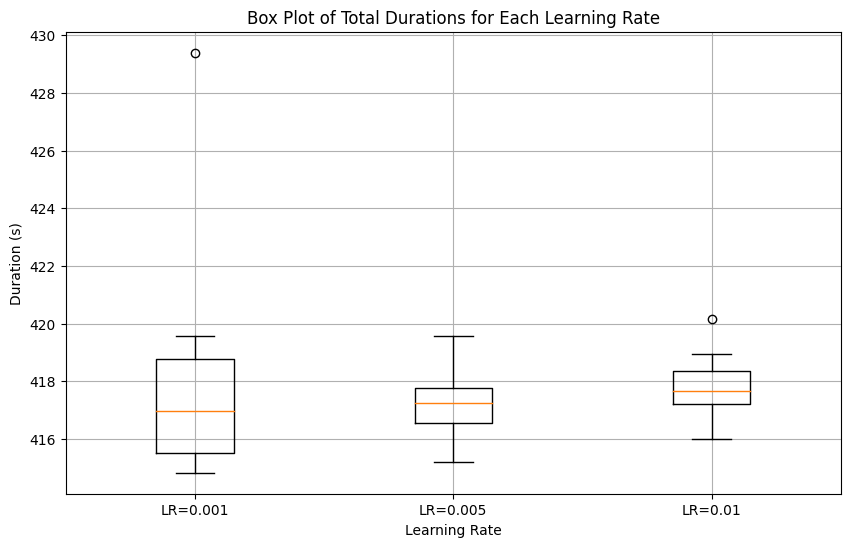

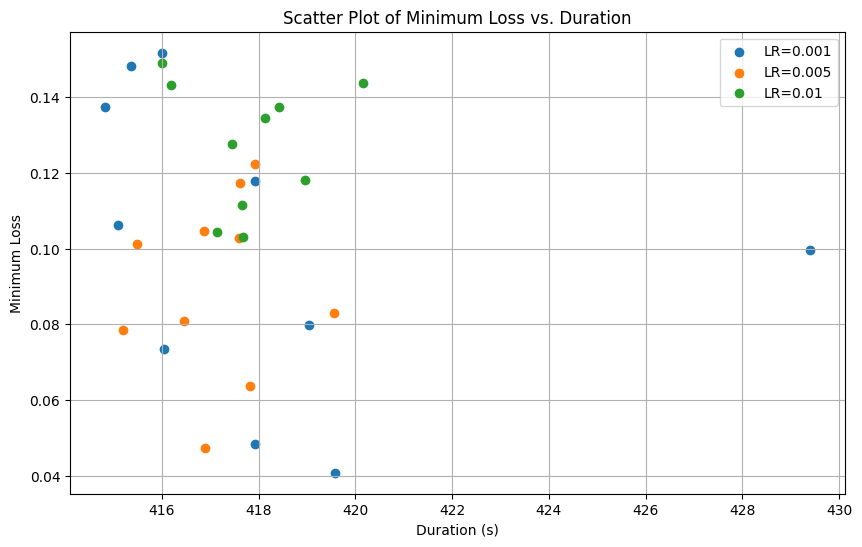

In [13]:
import matplotlib.pyplot as plt

# Assuming `results` is a list of lists with the structure [learning_rate, run, (min_loss, iteration), duration]

# Extract data for plotting
learning_rates = sorted(set(result[0] for result in results))
num_runs = len([result for result in results if result[0] == learning_rates[0]])

# Prepare data for plotting
loss_data = {lr: [] for lr in learning_rates}
time_data = {lr: [] for lr in learning_rates}

for result in results:
    lr, run, (min_loss, _), duration = result
    loss_data[lr].append(min_loss)
    time_data[lr].append(duration)

# Plot minimum loss for each run
plt.figure(figsize=(10, 6))
for lr in learning_rates:
    plt.plot(range(1, num_runs + 1), loss_data[lr], marker='o', label=f'LR={lr}')
plt.xlabel('Run')
plt.ylabel('Minimum Loss')
plt.title('Minimum Loss for Each Run Across Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()

# Plot total time for each run
plt.figure(figsize=(10, 6))
for lr in learning_rates:
    plt.plot(range(1, num_runs + 1), time_data[lr], marker='o', label=f'LR={lr}')
plt.xlabel('Run')
plt.ylabel('Duration (s)')
plt.title('Total Time for Each Run Across Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()

# Box plot of minimum losses
plt.figure(figsize=(10, 6))
plt.boxplot([loss_data[lr] for lr in learning_rates], labels=[f'LR={lr}' for lr in learning_rates])
plt.xlabel('Learning Rate')
plt.ylabel('Minimum Loss')
plt.title('Box Plot of Minimum Losses for Each Learning Rate')
plt.grid(True)
plt.show()

# Box plot of total durations
plt.figure(figsize=(10, 6))
plt.boxplot([time_data[lr] for lr in learning_rates], labels=[f'LR={lr}' for lr in learning_rates])
plt.xlabel('Learning Rate')
plt.ylabel('Duration (s)')
plt.title('Box Plot of Total Durations for Each Learning Rate')
plt.grid(True)
plt.show()

# Scatter plot of minimum loss vs. duration
plt.figure(figsize=(10, 6))
for lr in learning_rates:
    plt.scatter(time_data[lr], loss_data[lr], label=f'LR={lr}')
plt.xlabel('Duration (s)')
plt.ylabel('Minimum Loss')
plt.title('Scatter Plot of Minimum Loss vs. Duration')
plt.legend()
plt.grid(True)
plt.show()
